In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from src.utils import get_cc_mat, get_dataset, non_stratify_split

### Get data

In [3]:
df = get_dataset(
    labels_file="./data/class_vector_train_ref.mat",
    params_file="./data/training_set_ref.mat",
    names_file="./data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}")

# Value counts of the stability label
print("***Value counts of the stability label:")
print(df["label"].value_counts(normalize=True).round(4))

df.head()

***Dataset shape: (200000, 259)
***Value counts of the stability label:
0    0.5287
1    0.4713
Name: label, dtype: float64


,BIO@atp_c,BIO@pyr_c,BIO@nad_c,BIO@g6p_c,BIO@oaa_c,BIO@f6p_c,BIO@nadph_c,BIO@nh4_c,BIO@o2_c,BIO@r5p_c,BIO@3pg_c,BIO@akg_m,BIO@accoa_c,BIO@pep_c,BIO@e4p_c,BIO@so4_c,HXT@glc_c,HXK@atp_c,HXK@glc_c,HXK@adp_c,HXK@g6p_c,PGI@g6p_c,PGI@f6p_c,PFK@f6p_c,PFK@atp_c,PFK@fbp_c,PFK@adp_c,FBA@fbp_c,FBA@t3p_c,FBA@dhap_c,TPI@dhap_c,TPI@t3p_c,ZWF@g6p_c,ZWF@nadp_c,ZWF@6pgl_c,ZWF@nadph_c,GND1@6pgl_c,GND1@6pgc_c,GND2@nadp_c,GND2@6pgc_c,...,ICL@icit_c,ICL@suc_c,ICL@glyx_c,MLS@accoa_c,MLS@glyx_c,MLS@coa_c,MLS@mal_c,XTR@xyl_c,XDH@nad_c,XDH@xlt_c,XDH@nadh_c,XDH@xyll_c,XRI@nadh_c,XRI@xyl_c,XRI@nad_c,XRI@xlt_c,XRII@nadph_c,XRII@xyl_c,XRII@nadp_c,XRII@xlt_c,XK@atp_c,XK@xyll_c,XK@adp_c,XK@x5p_c,XLT@xlt_c,D_LACt2r@lac_c,D_LACm2r@lac_m,D_LACm2r@lac_c,D_LAC@fero_m,D_LAC@pyr_m,D_LAC@feri_m,D_LAC@lac_m,SUCCt2r@suc_c,MALt2r@mal_c,CITt2m@mal_c,CITt2m@cit_m,CITt2m@mal_m,CITt2m@cit_c,PFK@amp_c,label
0,0.457634,0.014440,0.058212,0.676883,0.341359,0.662601,0.558494,0.469465,0.379688,0.031882,0.099014,0.917409,0.843736,0.646167,0.794358,0.683359,0.736572,0.146874,0.641442,0.629566,0.695658,0.805839,0.806237,0.875210,0.864747,0.966937,0.567908,0.977325,0.600069,0.502606,0.146862,0.946764,0.795935,0.427475,0.552705,0.485171,0.252212,0.997275,0.864418,0.959533,...,0.924751,0.437875,0.621754,0.831827,0.303100,0.720146,0.657864,0.613027,0.321156,0.522470,0.943940,0.883506,0.262150,0.412281,0.837449,0.830384,0.929544,0.216103,0.715890,0.819011,0.626448,0.805179,0.534479,0.232007,0.421447,0.012541,0.701124,0.778910,0.744105,0.406664,0.310612,0.176318,0.750574,0.835077,0.636952,0.805681,0.314653,0.601644,0.442062,1
1,0.011809,0.879388,0.003459,0.746891,0.306732,0.324433,0.790872,0.561433,0.601143,0.729455,0.210557,0.549802,0.200915,0.901595,0.453948,0.997632,0.490716,0.278574,0.344656,0.251129,0.788420,0.606969,0.904826,0.207650,0.894433,0.835846,0.866860,0.283239,0.566340,0.563007,0.013364,0.534063,0.951530,0.571236,0.481585,0.272074,0.593773,0.674854,0.404115,0.811138,...,0.821184,0.820805,0.258968,0.268113,0.633285,0.799704,0.089733,0.955897,0.572365,0.296768,0.776485,0.907100,0.134346,0.130297,0.447560,0.369458,0.986246,0.958851,0.674634,0.873138,0.328043,0.258325,0.496081,0.394231,0.126339,0.518405,0.074353,0.343389,0.261749,0.552473,0.260641,0.480122,0.828887,0.774984,0.793254,0.111233,0.174306,0.035144,0.432545,1
2,0.150170,0.442691,0.029388,0.930178,0.904467,0.690296,0.083225,0.292097,0.122153,0.097039,0.198740,0.371718,0.727785,0.520097,0.515522,0.862993,0.733933,0.725326,0.602793,0.493402,0.461824,0.016081,0.677892,0.880626,0.283048,0.024288,0.591687,0.095995,0.272931,0.507377,0.447012,0.309567,0.062153,0.074500,0.636656,0.968372,0.650881,0.592212,0.181818,0.427867,...,0.294319,0.114383,0.397159,0.813008,0.410090,0.233548,0.643357,0.087580,0.437366,0.435850,0.536274,0.652505,0.641738,0.516002,0.936964,0.989159,0.495483,0.267238,0.468767,0.203659,0.151049,0.162482,0.120060,0.569019,0.134233,0.229017,0.894372,0.499494,0.084862,0.962005,0.780362,0.548510,0.591525,0.579699,0.168482,0.214867,0.430102,0.757192,0.281138,1
3,0.241337,0.108236,0.874900,0.908554,0.945598,0.204189,0.396873,0.474224,0.738103,0.958655,0.012677,0.705030,0.637421,0.426836,0.553545,0.056516,0.166585,0.992412,0.350366,0.688583,0.600025,0.416167,0.797132,0.276558,0.395847,0.287797,0.026588,0.623333,0.483995,0.709361,0.691944,0.432705,0.550024,0.615881,0.854155,0.041522,0.550175,0.879892,0.771858,0.587855,...,0.050599,0.978312,0.361124,0.060349,0.454177,0.592409,0.194631,0.286367,0.714915,0.917447,0.385828,0.978640,0.226889,0.437499,0.570366,0.723278,0.635307,0.986755,0.186288,0.777968,0.397245,0.706944,0.341994,0.385962,0.336215,0.335343,0.301915,0.734281,0.667319,0.697372,0.998683,0.015408,0.362024,0.127115,0.230577,0.996991,0.195371,0.013773,0.316083,1
4,0.357361,0.179095,0.737178,0.371373,0.562450,0.809965,0.920162,0.750900,0.623332,0.356794,0.591810,0.046342,0.876380,0.092701,0.737494,0.650255,0.688438,0.697684,0.820405,0.603259,0.627316,0.742949,0.580344,0.944828,0.903211,0.957172,0.691398,0.438

### Feature Selection

In [4]:
# from mrmr import mrmr_classif

# K = int(df.drop("label", axis=1).shape[1] / 3)
# print(f"***Number of features to select: {K}")
# selected_features = mrmr_classif(X=df.drop("label", axis=1), y=df["label"], K=K)

### FFC

In [5]:
enzyme, commonEnz, allEnzymes, commonConCoeff, allConCoeff = get_cc_mat("./data/ccXTR_ref.mat")


Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


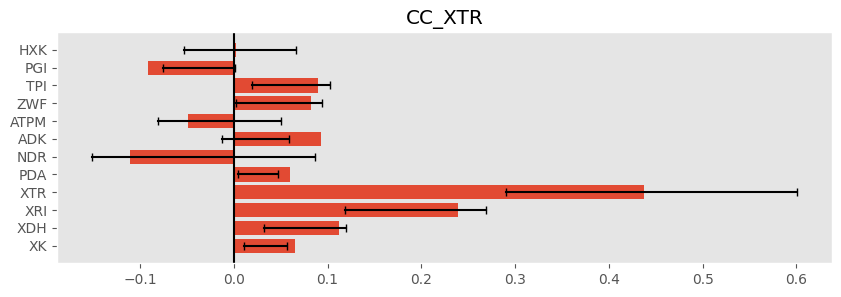

In [6]:
# Change plot style
plt.style.use("ggplot")

# Calculate the 1st and 3rd quartiles of commonConCoeff values
q1 = commonConCoeff.quantile(0.25)
q3 = commonConCoeff.quantile(0.75)

# Plot the mean of commonConCoeff values
plt.figure(figsize=(10, 3))
plt.barh(commonConCoeff.columns[::-1], commonConCoeff.mean()[::-1])
plt.axvline(x=0, color="black", linestyle="-")
plt.plot(q1, commonConCoeff.columns, "|", color="black", label="Q1", alpha=1)
plt.plot(q3, commonConCoeff.columns, "|", color="black", label="Q3", alpha=1)
for i, enzyme in enumerate(commonConCoeff.columns):
    plt.plot([q1[i], q3[i]], [enzyme, enzyme], color="black")
plt.title("CC_XTR")
plt.grid()
plt.show()

### Dataset formulation

In [7]:
idx_HXK = commonConCoeff[commonConCoeff["HXK"] < 0].index
df_HXK = df.drop("label", axis=1)
df_HXK["label"] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK["label"].value_counts(normalize=True).round(4)

0    0.5287
1    0.4713
Name: label, dtype: float64

In [8]:
# # Keep only the features selected by mRMR
# df_HXK = df_HXK[selected_features + ["label"]]
# print(f"***Dataset shape: {df_HXK.shape}")

In [9]:
# Split data
X_train, X_test, y_train, y_test = non_stratify_split(
    data=df_HXK, train_size=10000, target="label"
)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

Traininig set shape: (10000, 258)
Test set shape: (190000, 258)


In [42]:
from src.machinelearning import train_skoperules

skope_rules_clf = train_skoperules(X_train, y_train, scoring='matthews_corrcoef')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START max_depth_duplication=2, max_samples=0.5, n_estimators=20, precision_min=0.1, recall_min=0.15
[CV 2/3; 1/50] START max_depth_duplication=2, max_samples=0.5, n_estimators=20, precision_min=0.1, recall_min=0.15
[CV 3/3; 1/50] START max_depth_duplication=2, max_samples=0.5, n_estimators=20, precision_min=0.1, recall_min=0.15
[CV 1/3; 2/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=30, precision_min=0.1, recall_min=0.1
[CV 2/3; 2/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=30, precision_min=0.1, recall_min=0.1
[CV 3/3; 2/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=30, precision_min=0.1, recall_min=0.1
[CV 1/3; 3/50] START max_depth_duplication=None, max_samples=0.2, n_estimators=20, precision_min=0.25, recall_min=0.25
[CV 2/3; 3/50] START max_depth_duplication=None, max_samples=0.2, n_estimators=20, precision_min=0.25, recall_min=0.25
[CV 3/3; 3/50

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 3/50] END max_depth_duplication=None, max_samples=0.2, n_estimators=20, precision_min=0.25, recall_min=0.25;, score=0.013 total time=  54.3s
[CV 1/3; 28/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=50, precision_min=0.25, recall_min=0.25
[CV 1/3; 16/50] END max_depth_duplication=1, max_samples=0.5, n_estimators=50, precision_min=0.1, recall_min=0.1;, score=0.127 total time=  53.0s
[CV 2/3; 28/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=50, precision_min=0.25, recall_min=0.25
[CV 1/3; 6/50] END max_depth_duplication=3, max_samples=0.25, n_estimators=20, precision_min=0.1, recall_min=0.2;, score=-0.019 total time=  55.3s
[CV 1/3; 29/50] START max_depth_duplication=3, max_samples=0.2, n_estimators=10, precision_min=0.1, recall_min=0.25
[CV 1/3; 23/50] END max_depth_duplication=1, max_samples=0.5, n_estimators=20, precision_min=0.2, recall_min=0.15;, score=0.114 total time=  23.5s
[CV 2/3; 29/50] START max_depth_duplication=3, max_samples=0

In [43]:
from src.machinelearning import evaluate_sklearn

evaluate_sklearn(skope_rules_clf, X_test, y_test)

Accuracy: 0.5621315789473684
Precision: 0.5318738035200755
Recall: 0.6949335566476409
F1 score: 0.6025672260678064
ROC AUC score: 0.5678131902698939
Matthews correlation coefficient: 0.1398666884758641


In [45]:
skope_rules_clf.rules_

[('ASN@pi_m <= 0.6622629165649414 and XRI@nadh_c <= 0.6211623549461365 and GND1@6pgl_c <= 0.9577304422855377',
  (0.3439306358381503, 0.4271356783919598, 2)),
 ('ASN@pi_m > 0.6795818507671356 and ASN@atp_m <= 0.9435464441776276 and XRI@nadh_c <= 0.7111899256706238',
  (0.5463552724699221, 0.2761087267525036, 2))]

In [10]:
# from src.machinelearning import train_decisiontree, evaluate_sklean

# cart_model = train_decisiontree(X_train, y_train, n_trials=200)

In [11]:
# display(cart_model)
# evaluate_sklean(cart_model, X_test, y_test)

In [12]:
# from src.ml2rules import TreeRuler, ml2tree

# ruler = TreeRuler(df=train, tree_clf=cart_model, target="label")
# ruler.get_rules()
# ruler.rules

In [13]:
# r = ruler.get_rule_constraints(1)
# print(r)
# print()

# _ = test[test["ASN@pi_m"] > 0.679]
# _ = _[_["XRI@nadh_c"] <= 0.633]
# _ = _[_["ASN@atp_m"] <= 0.573]

# print(f"Number of samples: {_.shape[0]}")
# print(_["label"].value_counts(normalize=True).round(4))
# print(_["label"].value_counts())

In [91]:
_ = test[test["ASN@pi_m"] > 0.679]
_ = _[_["XRI@nadh_c"] <= 0.748]
_ = _[_["ASN@atp_m"] <= 0.944]
_["label"].value_counts(normalize=True).round(4)

1    0.6548
0    0.3452
Name: label, dtype: float64

In [15]:
# Train ANNClassifier
import torch
from src.machinelearning import ANNClassifier, train, evaluate, get_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train.shape[1]
hidden_dim = 2048
output_dim = 1
hidden_layers = 4

model = ANNClassifier(input_dim, hidden_dim, output_dim, hidden_layers).to(device)

model = train(
    model, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048
)

# Evaluate model
evaluate(model, X_test, y_test)

Epoch 0, Loss: 0.680859
Epoch 10, Loss: 0.529382
Epoch 20, Loss: 0.378249
Epoch 30, Loss: 0.431200
Epoch 40, Loss: 0.126426
Epoch 50, Loss: 0.000825
Epoch 60, Loss: 0.000096
Epoch 70, Loss: 0.000040
Epoch 80, Loss: 0.000021
Epoch 90, Loss: 0.000013
Epoch 100, Loss: 0.000008
Epoch 110, Loss: 0.000005
Epoch 120, Loss: 0.000005
Epoch 130, Loss: 0.000004
Epoch 140, Loss: 0.000003
Epoch 150, Loss: 0.000002
Epoch 160, Loss: 0.000002
Epoch 170, Loss: 0.000002
Epoch 180, Loss: 0.000002
Epoch 190, Loss: 0.000001
Epoch 200, Loss: 0.000001
Epoch 210, Loss: 0.000001
Epoch 220, Loss: 0.000001
Epoch 230, Loss: 0.000001
Epoch 240, Loss: 0.000001
Epoch 250, Loss: 0.000001
Epoch 260, Loss: 0.000001
Epoch 270, Loss: 0.000001
Epoch 280, Loss: 0.000001
Epoch 290, Loss: 0.000001
Early stopping on epoch 294
Accuracy: 0.6254157894736843
Precision: 0.6455271019425413
Recall: 0.4785794565528792
F1: 0.5496560931933661
MCC: 0.24885660465616025


In [16]:
ann_preds = get_predictions(model, X_train)

In [17]:
ann2tree = ml2tree(X_train, ann_preds, n_trials=200)

[I 2024-09-30 13:10:05,369] A new study created in memory with name: no-name-c9730b68-c107-4e71-9da8-0f8ad2f865b2
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07512092590332031s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:05,559] Trial 0 finished with value: 0.6023005419918116 and parameters: {'max_depth': 13, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6023005419918116.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.605) total time=   0.1s
[CV] END ................................ score: (test=0.597) total time=   0.1s
[CV] END ................................ score: (test=0.605) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.10758757591247559s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:05,794] Trial 1 finished with value: 0.5925993319187948 and parameters: {'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6023005419918116.


[CV] END ................................ score: (test=0.599) total time=   0.1s
[CV] END ................................ score: (test=0.599) total time=   0.1s
[CV] END ................................ score: (test=0.580) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:06,552] Trial 2 finished with value: 0.6177996923867551 and parameters: {'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.6177996923867551.


[CV] END ................................ score: (test=0.621) total time=   0.6s
[CV] END ................................ score: (test=0.611) total time=   0.6s
[CV] END ................................ score: (test=0.622) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0783073902130127s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:06,756] Trial 3 finished with value: 0.5871996317808146 and parameters: {'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 2 with value: 0.6177996923867551.


[CV] END ................................ score: (test=0.591) total time=   0.1s
[CV] END ................................ score: (test=0.578) total time=   0.1s
[CV] END ................................ score: (test=0.593) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:07,465] Trial 4 finished with value: 0.6134996523047626 and parameters: {'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 2 with value: 0.6177996923867551.


[CV] END ................................ score: (test=0.617) total time=   0.5s
[CV] END ................................ score: (test=0.602) total time=   0.6s
[CV] END ................................ score: (test=0.621) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06898379325866699s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:07,660] Trial 5 finished with value: 0.6125985723947319 and parameters: {'max_depth': 10, 'min_samples_split': 21, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.6177996923867551.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.592) total time=   0.1s
[CV] END ................................ score: (test=0.627) total time=   0.1s
[CV] END ................................ score: (test=0.619) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.651) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.651) total time=   0.0s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.05242276191711426s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:07,834] Trial 6 finished with value: 0.6507999630196973 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.6507999630196973.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07733583450317383s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:08,030] Trial 7 finished with value: 0.588100771684847 and parameters: {'max_depth': 23, 'min_samples_split': 25, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 6 with value: 0.6507999630196973.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.580) total time=   0.1s
[CV] END ................................ score: (test=0.592) total time=   0.1s
[CV] END ................................ score: (test=0.592) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:08,720] Trial 8 finished with value: 0.6185998023917568 and parameters: {'max_depth': 16, 'min_samples_split': 21, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 6 with value: 0.6507999630196973.


[CV] END ................................ score: (test=0.621) total time=   0.5s
[CV] END ................................ score: (test=0.607) total time=   0.5s
[CV] END ................................ score: (test=0.629) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:09,410] Trial 9 finished with value: 0.6112997022557684 and parameters: {'max_depth': 21, 'min_samples_split': 21, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 6 with value: 0.6507999630196973.


[CV] END ................................ score: (test=0.614) total time=   0.5s
[CV] END ................................ score: (test=0.603) total time=   0.5s
[CV] END ................................ score: (test=0.617) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.054480791091918945s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:09,598] Trial 10 finished with value: 0.6510995430676841 and parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.656) total time=   0.0s
[CV] END ................................ score: (test=0.653) total time=   0.0s
[CV] END ................................ score: (test=0.644) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.636) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.04613041877746582s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:09,775] Trial 11 finished with value: 0.6453008828177359 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04768252372741699s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:09,951] Trial 12 finished with value: 0.6485998629856987 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.646) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.07746076583862305s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:10,159] Trial 13 finished with value: 0.6275015323967909 and parameters: {'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.


[CV] END ................................ score: (test=0.612) total time=   0.1s
[CV] END ................................ score: (test=0.634) total time=   0.1s
[CV] END ................................ score: (test=0.636) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.641) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0708765983581543s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:10,368] Trial 14 finished with value: 0.6402999628097182 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.


[CV] END ................................ score: (test=0.638) total time=   0.1s
[CV] END ................................ score: (test=0.642) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07190942764282227s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:10,577] Trial 15 finished with value: 0.637300052740727 and parameters: {'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.


[CV] END ................................ score: (test=0.637) total time=   0.1s
[CV] END ................................ score: (test=0.647) total time=   0.1s
[CV] END ................................ score: (test=0.629) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.646) total time=   0.0s
[CV] END ................................ score: (test=0.655) total time=   0.0s
[CV] END ................................ score: (test=0.646) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05923032760620117s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:10,774] Trial 16 finished with value: 0.6489993930406838 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09372472763061523s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:11,012] Trial 17 finished with value: 0.6149994123587524 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.621) total time=   0.1s
[CV] END ................................ score: (test=0.616) total time=   0.1s
[CV] END ................................ score: (test=0.608) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08854341506958008s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:11,243] Trial 18 finished with value: 0.6265009524347755 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.1s
[CV] END ................................ score: (test=0.629) total time=   0.1s
[CV] END ................................ score: (test=0.633) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0608983039855957s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:11,442] Trial 19 finished with value: 0.6465005528747235 and parameters: {'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.653) total time=   0.0s
[CV] END ................................ score: (test=0.641) total time=   0.0s
[CV] END ................................ score: (test=0.645) total time=   0.0s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0879218578338623s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:11,671] Trial 20 finished with value: 0.6402995428517056 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6510995430676841.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.645) total time=   0.1s
[CV] END ................................ score: (test=0.639) total time=   0.1s
[CV] END ................................ score: (test=0.637) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0591428279876709s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:11,871] Trial 21 finished with value: 0.6532997630896863 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.656) total time=   0.0s
[CV] END ................................ score: (test=0.660) total time=   0.0s
[CV] END ................................ score: (test=0.644) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.05968213081359863s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:12,069] Trial 22 finished with value: 0.649599843007696 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 23, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.651) total time=   0.0s
[CV] END ................................ score: (test=0.649) total time=   0.0s
[CV] END ................................ score: (test=0.648) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.651) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.04552602767944336s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:12,249] Trial 23 finished with value: 0.6502999430116977 and parameters: {'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06212449073791504s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:12,450] Trial 24 finished with value: 0.6420004627937299 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 22, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.651) total time=   0.0s
[CV] END ................................ score: (test=0.637) total time=   0.1s
[CV] END ................................ score: (test=0.638) total time=   0.0s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.08988380432128906s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:12,680] Trial 25 finished with value: 0.6214002024077633 and parameters: {'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.619) total time=   0.1s
[CV] END ................................ score: (test=0.617) total time=   0.1s
[CV] END ................................ score: (test=0.628) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08078598976135254s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:12,901] Trial 26 finished with value: 0.6254006624417691 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.629) total time=   0.1s
[CV] END ................................ score: (test=0.619) total time=   0.1s
[CV] END ................................ score: (test=0.628) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09159088134765625s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:13,130] Trial 27 finished with value: 0.6058995521627748 and parameters: {'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.612) total time=   0.1s
[CV] END ................................ score: (test=0.610) total time=   0.1s
[CV] END ................................ score: (test=0.595) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04980015754699707s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:13,320] Trial 28 finished with value: 0.6501000429977011 and parameters: {'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:14,017] Trial 29 finished with value: 0.6176997723767577 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 21 with value: 0.6532997630896863.


[CV] END ................................ score: (test=0.607) total time=   0.5s
[CV] END ................................ score: (test=0.620) total time=   0.5s
[CV] END ................................ score: (test=0.626) total time=   0.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.649) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04136347770690918s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 13:10:14,197] Trial 30 finished with value: 0.6497000629877024 and parameters: {'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.044904232025146484s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:14,377] Trial 31 finished with value: 0.651900193018702 and parameters: {'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBacke

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.656) total time=   0.0s
[CV] START .....................................................................[CV] START .....................................................................

[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.07152986526489258s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:14,588] Trial 32 finished with value: 0.6389993528447026 and parameters: {'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 23, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.


[CV] END ................................ score: (test=0.645) total time=   0.1s
[CV] END ................................ score: (test=0.643) total time=   0.1s
[CV] END ................................ score: (test=0.629) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.653) total time=   0.0s
[CV] END ................................ score: (test=0.652) total time=   0.0s
[CV] END ................................ score: (test=0.652) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05228424072265625s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:14,778] Trial 33 finished with value: 0.6522999330526934 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 22, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06537365913391113s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:14,977] Trial 34 finished with value: 0.644699712922702 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 22, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.648) total time=   0.1s
[CV] END ................................ score: (test=0.651) total time=   0.0s
[CV] END ................................ score: (test=0.635) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.051458120346069336s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:15,165] Trial 35 finished with value: 0.6501006129407182 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.644) total time=   0.0s
[CV] END ................................ score: (test=0.656) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[I 2024-09-30 13:10:15,760] Trial 36 finished with value: 0.6420008527547415 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 21 with value: 0.6532997630896863.


[CV] END ................................ score: (test=0.633) total time=   0.4s
[CV] END ................................ score: (test=0.634) total time=   0.4s
[CV] END ................................ score: (test=0.658) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09401321411132812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:15,991] Trial 37 finished with value: 0.608401332034823 and parameters: {'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.


[CV] END ................................ score: (test=0.611) total time=   0.1s
[CV] END ................................ score: (test=0.619) total time=   0.1s
[CV] END ................................ score: (test=0.595) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06820845603942871s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:16,201] Trial 38 finished with value: 0.6217025421798329 and parameters: {'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 24, 'max_features': 'log2'}. Best is trial 21 with value: 0.6532997630896863.


[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] END ................................ score: (test=0.625) total time=   0.1s
[CV] END ................................ score: (test=0.644) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10650157928466797s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:16,441] Trial 39 finished with value: 0.6105006121487974 and parameters: {'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.6532997630896863.


[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.621) total time=   0.1s
[CV] END ................................ score: (test=0.604) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:16,813] Trial 40 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:17,184] Trial 41 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:17,707] Trial 42 finished with value: 0.6489000729707044 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.645) total time=   0.3s
[CV] END ................................ score: (test=0.648) total time=   0.4s
[CV] END ................................ score: (test=0.654) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:18,080] Trial 43 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:18,441] Trial 44 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:18,821] Trial 45 finished with value: 0.6500001829817054 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.655) total time=   0.3s
[CV] END ................................ score: (test=0.647) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[I 2024-09-30 13:10:19,405] Trial 46 finished with value: 0.6445012527647486 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.632) total time=   0.4s
[CV] END ................................ score: (test=0.637) total time=   0.4s
[CV] END ................................ score: (test=0.664) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:19,774] Trial 47 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:20,147] Trial 48 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:20,690] Trial 49 finished with value: 0.6495014228477437 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.635) total time=   0.4s
[CV] END ................................ score: (test=0.668) total time=   0.4s
[CV] END ................................ score: (test=0.646) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[I 2024-09-30 13:10:21,333] Trial 50 finished with value: 0.6371997427697179 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.640) total time=   0.5s
[CV] END ................................ score: (test=0.632) total time=   0.5s
[CV] END ................................ score: (test=0.639) total time=   0.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:21,706] Trial 51 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16756033897399902s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:22,007] Trial 52 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:22,379] Trial 53 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:22,822] Trial 54 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:23,307] Trial 55 finished with value: 0.6503002129847059 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.647) total time=   0.3s
[CV] END ................................ score: (test=0.656) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:23,692] Trial 56 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:24,226] Trial 57 finished with value: 0.6460009228277356 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.637) total time=   0.4s
[CV] END ................................ score: (test=0.655) total time=   0.4s
[CV] END ................................ score: (test=0.646) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1690382957458496s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:24,528] Trial 58 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:24,961] Trial 59 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[I 2024-09-30 13:10:25,626] Trial 60 finished with value: 0.6246006424277701 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.610) total time=   0.5s
[CV] END ................................ score: (test=0.646) total time=   0.5s
[CV] END ................................ score: (test=0.618) total time=   0.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:25,989] Trial 61 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:26,362] Trial 62 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s[CV] END ................................ score: (test=0.667) total time=   0.2s

[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.167464017868042s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:26,664] Trial 63 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:27,421] Trial 64 finished with value: 0.6161001823037733 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.614) total time=   0.6s
[CV] END ................................ score: (test=0.616) total time=   0.6s
[CV] END ................................ score: (test=0.618) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:27,906] Trial 65 finished with value: 0.6518003629997073 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.664) total time=   0.3s
[CV] END ................................ score: (test=0.643) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:28,340] Trial 66 finished with value: 0.6573004031056975 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:28,712] Trial 67 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16747689247131348s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:29,014] Trial 68 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:29,548] Trial 69 finished with value: 0.6475012228277417 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.635) total time=   0.4s
[CV] END ................................ score: (test=0.646) total time=   0.4s
[CV] END ................................ score: (test=0.661) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.642) total time=   0.0s
[CV] END ................................ score: (test=0.641) total time=   0.0s
[CV] END ................................ score: (test=0.645) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0500941276550293s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:29,740] Trial 70 finished with value: 0.6427000228517152 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 24, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:30,124] Trial 71 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:30,498] Trial 72 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:30,992] Trial 73 finished with value: 0.6519003730007075 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.644) total time=   0.3s
[CV] END ................................ score: (test=0.664) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16720223426818848s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:31,293] Trial 74 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:31,738] Trial 75 finished with value: 0.6573004031056975 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:32,110] Trial 76 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:32,848] Trial 77 finished with value: 0.6174999923507647 and parameters: {'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.618) total time=   0.5s
[CV] END ................................ score: (test=0.624) total time=   0.6s
[CV] END ................................ score: (test=0.611) total time=   0.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:33,302] Trial 78 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06300568580627441s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:33,504] Trial 79 finished with value: 0.6343981128766746 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.620) total time=   0.0s
[CV] END ................................ score: (test=0.653) total time=   0.0s
[CV] END ................................ score: (test=0.630) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.16366815567016602s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:33,808] Trial 80 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.1s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:34,193] Trial 81 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:34,568] Trial 82 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:35,055] Trial 83 finished with value: 0.6519003730007075 and parameters: {'max_depth': 5, 'min_samples_split': 23, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.644) total time=   0.3s
[CV] END ................................ score: (test=0.664) total time=   0.3s
[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:35,508] Trial 84 finished with value: 0.6571003831036973 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1679246425628662s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:35,822] Trial 85 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.647) total time=   0.1s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:36,196] Trial 86 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:36,679] Trial 87 finished with value: 0.6527004530087082 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.647) total time=   0.3s
[CV] END ................................ score: (test=0.663) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:37,103] Trial 88 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:37,647] Trial 89 finished with value: 0.6484013728307444 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.635) total time=   0.4s
[CV] END ................................ score: (test=0.668) total time=   0.4s
[CV] END ................................ score: (test=0.642) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06883573532104492s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:37,858] Trial 90 finished with value: 0.6240003724427631 and parameters: {'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 23, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.620) total time=   0.1s
[CV] END ................................ score: (test=0.625) total time=   0.1s
[CV] END ................................ score: (test=0.626) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:38,229] Trial 91 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16916537284851074s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:38,543] Trial 92 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:38,915] Trial 93 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:39,280] Trial 94 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16897296905517578s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:39,583] Trial 95 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:40,048] Trial 96 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:40,488] Trial 97 finished with value: 0.6571004430976991 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:40,995] Trial 98 finished with value: 0.6529004130167065 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.649) total time=   0.3s
[CV] END ................................ score: (test=0.646) total time=   0.3s
[CV] END ................................ score: (test=0.664) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1709442138671875s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:41,320] Trial 99 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:41,695] Trial 100 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:42,130] Trial 101 finished with value: 0.6570003731026972 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:42,505] Trial 102 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16424059867858887s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:42,809] Trial 103 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:43,185] Trial 104 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:43,622] Trial 105 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:44,109] Trial 106 finished with value: 0.6519003730007075 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.3s
[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.644) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16454553604125977s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:44,411] Trial 107 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.1s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:44,896] Trial 108 finished with value: 0.6516003429977072 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.663) total time=   0.3s
[CV] END ................................ score: (test=0.643) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.638) total time=   0.0s
[CV] END ................................ score: (test=0.654) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.044968605041503906s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 13:10:45,078] Trial 109 finished with value: 0.6475997629756978 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:45,624] Trial 110 finished with value: 0.6496014328487437 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.635) total time=   0.4s
[CV] END ................................ score: (test=0.646) total time=   0.4s
[CV] END ................................ score: (test=0.668) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:46,005] Trial 111 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:46,430] Trial 112 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16743993759155273s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:46,744] Trial 113 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:47,110] Trial 114 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s[CV] END ................................ score: (test=0.654) total time=   0.2s

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:47,837] Trial 115 finished with value: 0.612999932266772 and parameters: {'max_depth': 23, 'min_samples_split': 23, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.604) total time=   0.6s
[CV] END ................................ score: (test=0.614) total time=   0.6s
[CV] END ................................ score: (test=0.621) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16705036163330078s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:48,142] Trial 116 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:48,506] Trial 117 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:48,934] Trial 118 finished with value: 0.6573004031056975 and parameters: {'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:49,308] Trial 119 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 24, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:49,804] Trial 120 finished with value: 0.6518003629997073 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.664) total time=   0.3s
[CV] END ................................ score: (test=0.643) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:50,171] Trial 121 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:50,605] Trial 122 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17061185836791992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:50,918] Trial 123 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 13:10:51,716] Trial 124 finished with value: 0.6073004121047978 and parameters: {'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.603) total time=   0.6s
[CV] END ................................ score: (test=0.618) total time=   0.6s
[CV] END ................................ score: (test=0.601) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1674048900604248s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:52,021] Trial 125 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:52,395] Trial 126 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:52,770] Trial 127 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.638) total time=   0.0s
[CV] END ................................ score: (test=0.654) total time=   0.0s
[CV] END ................................ score: (test=0.639) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04999399185180664s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:10:52,953] Trial 128 finished with value: 0.6439005628217291 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:53,420] Trial 129 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:53,794] Trial 130 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:54,159] Trial 131 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1658933162689209s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:54,463] Trial 132 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:54,888] Trial 133 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1687304973602295s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:55,232] Trial 134 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:55,598] Trial 135 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:10:56,085] Trial 136 finished with value: 0.6496001429777051 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.645) total time=   0.3s
[CV] END ................................ score: (test=0.656) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:56,460] Trial 137 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:10:57,169] Trial 138 finished with value: 0.6128997422837664 and parameters: {'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.615) total time=   0.5s
[CV] END ................................ score: (test=0.605) total time=   0.5s
[CV] END ................................ score: (test=0.618) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:57,618] Trial 139 finished with value: 0.6573004031056975 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16256499290466309s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:57,932] Trial 140 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.1s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:58,309] Trial 141 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:58,746] Trial 142 finished with value: 0.6573004031056975 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17086100578308105s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:59,061] Trial 143 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:10:59,429] Trial 144 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:10:59,877] Trial 145 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.3s
[CV] END ................................ score: (test=0.662) total time=   0.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:11:00,618] Trial 146 finished with value: 0.6133997622917661 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.616) total time=   0.5s
[CV] END ................................ score: (test=0.605) total time=   0.5s
[CV] END ................................ score: (test=0.620) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:01,056] Trial 147 finished with value: 0.6568003531006971 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:01,422] Trial 148 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04059624671936035s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 13:11:01,604] Trial 149 finished with value: 0.6500999830036993 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 22, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:11:02,102] Trial 150 finished with value: 0.6523004130047078 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.645) total time=   0.3s
[CV] END ................................ score: (test=0.648) total time=   0.3s
[CV] END ................................ score: (test=0.664) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:02,466] Trial 151 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:02,892] Trial 152 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:03,287] Trial 153 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:11:03,926] Trial 154 finished with value: 0.6154997923307627 and parameters: {'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.618) total time=   0.6s
[CV] END ................................ score: (test=0.611) total time=   0.6s
[CV] END ................................ score: (test=0.618) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16694974899291992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:04,231] Trial 155 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:04,606] Trial 156 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s[CV] END ................................ score: (test=0.654) total time=   0.2s

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[I 2024-09-30 13:11:05,295] Trial 157 finished with value: 0.6193000523807629 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.619) total time=   0.5s
[CV] END ................................ score: (test=0.611) total time=   0.5s
[CV] END ................................ score: (test=0.628) total time=   0.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1652524471282959s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:05,601] Trial 158 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 22, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:06,038] Trial 159 finished with value: 0.6571003831036973 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:06,474] Trial 160 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:06,850] Trial 161 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:07,236] Trial 162 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:07,601] Trial 163 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16863107681274414s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:07,905] Trial 164 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:08,285] Trial 165 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:08,720] Trial 166 finished with value: 0.6573004031056975 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:09,156] Trial 167 finished with value: 0.6571004430976991 and parameters: {'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.667) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:09,534] Trial 168 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.649) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04873347282409668s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:11:09,719] Trial 169 finished with value: 0.6495999629956998 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16799354553222656s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s


[I 2024-09-30 13:11:10,043] Trial 170 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:10,409] Trial 171 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:10,789] Trial 172 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:11,217] Trial 173 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:11,583] Trial 174 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16853713989257812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:11,888] Trial 175 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:12,263] Trial 176 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:12,699] Trial 177 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.650) total time=   0.0s
[CV] END ................................ score: (test=0.652) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04027128219604492s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 13:11:12,882] Trial 178 finished with value: 0.6506000630057007 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 24, 'max_features': 'log2'}. Best is trial 40 with value: 0.6608999232256759.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:11:13,420] Trial 179 finished with value: 0.6496001429777051 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.645) total time=   0.3s
[CV] END ................................ score: (test=0.656) total time=   0.4s
[CV] END ................................ score: (test=0.648) total time=   0.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:13,856] Trial 180 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:14,223] Trial 181 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:14,599] Trial 182 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:14,975] Trial 183 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16784167289733887s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:15,280] Trial 184 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 13:11:15,766] Trial 185 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:16,163] Trial 186 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16656780242919922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:16,470] Trial 187 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.664) total time=   0.1s
[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:16,918] Trial 188 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 13:11:17,649] Trial 189 finished with value: 0.6195004923407758 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.618) total time=   0.6s
[CV] END ................................ score: (test=0.615) total time=   0.6s
[CV] END ................................ score: (test=0.626) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:18,015] Trial 190 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:18,393] Trial 191 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:18,772] Trial 192 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:19,139] Trial 193 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16812777519226074s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:19,446] Trial 194 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:19,882] Trial 195 finished with value: 0.6569003631016971 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:20,259] Trial 196 finished with value: 0.6608999232256759 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.662) total time=   0.2s
[CV] END ................................ score: (test=0.654) total time=   0.2s
[CV] END ................................ score: (test=0.667) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 13:11:20,717] Trial 197 finished with value: 0.6567003430996969 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.651) total time=   0.3s
[CV] END ................................ score: (test=0.653) total time=   0.3s
[CV] END ................................ score: (test=0.666) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16895151138305664s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 13:11:21,033] Trial 198 finished with value: 0.6556000531066905 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.655) total time=   0.2s
[CV] END ................................ score: (test=0.664) total time=   0.2s
[CV] END ................................ score: (test=0.647) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09104418754577637s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 13:11:21,267] Trial 199 finished with value: 0.6113992323047541 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.6608999232256759.


[CV] END ................................ score: (test=0.605) total time=   0.1s
[CV] END ................................ score: (test=0.619) total time=   0.1s
[CV] END ................................ score: (test=0.610) total time=   0.1s


In [18]:
display(ann2tree)
evaluate_sklean(ann2tree, X_test, y_test)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=19, min_samples_split=7)

Accuracy: 0.572878947368421
Precision: 0.6747733644009175
Recall: 0.20422240342023493
F1 score: 0.3135483543532875
ROC AUC score: 0.5571068690417984
Matthews correlation coefficient: 0.16223006794716527


In [19]:
train = pd.concat([X_train, y_train], axis=1)
ruler = TreeRuler(df=train, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

['if (ASN@pi_m > 0.679) and (XRI@nadh_c <= 0.633) and (ASN@atp_m <= 0.573) then class: 1 (proba: 60.97%) | based on 889 samples',
 'if (ASN@pi_m <= 0.679) and (XRI@nadh_c <= 0.526) and (GND1@6pgl_c > 0.942) then class: 1 (proba: 57.71%) | based on 227 samples',
 'if (ASN@pi_m > 0.679) and (XRI@nadh_c > 0.633) and (GND1@6pgl_c > 0.82) then class: 1 (proba: 56.28%) | based on 215 samples']

In [ ]:
ruler.get_rule_constraints(0)

In [ ]:
_ = test[test["ASN@pi_m"] > 0.679]
_ = _[_["XRI@nadh_c"] <= 0.633]
_ = _[_["ASN@atp_m"] <= 0.573]

print(f"Number of samples: {_.shape[0]}")
print(_["label"].value_counts(normalize=True).round(4))
print(_["label"].value_counts())

In [66]:
import shap


# Calculate shap values for the ANN model
def f(x):
    return model(torch.tensor(x, dtype=torch.float32)).detach().numpy()


X_shap = shap.utils.sample(X_train, 100)
explainer = shap.KernelExplainer(f, X_shap)

In [ ]:
shap_values = explainer.shap_values(X_train.sample(300))

In [ ]:
fig = plt.figure()
shap.summary_plot(shap_values[0], X_shap, plot_type="dot", show=False)
plt.gcf().set_size_inches(10, 4)
plt.show()
